<a href="https://colab.research.google.com/github/syuan0525/project-team/blob/main/motomodelIRNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 讀取 google drive圖檔 :

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import glob
gp = glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外拍及網路)/KYMCO_GP/*.jpg") + glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含不用裁的)/KYM_GP_125_裁/*.jpg")
# 活力 125 原始+ 裁
vivo = glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外拍及網路)/SYM_活力/*.jpg") + glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含不用裁的)/SYM_活力_125_裁/*.jpg")

# 勁戰六代 原始+ 裁
gryphus6 = glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外拍及網路)/YAMAHA_六代勁戰/*.jpg") + glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含不用裁的)/YAMAHA_六代勁戰_125_裁/*.jpg")

# SYM JET SR  ...
SR = glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外拍及網路)/SYM_JET_SR/*.jpg") + glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含不用裁的)/SYM_JET_SR_125_裁/*.jpg")

# DRG
DRG = glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外拍及網路)/SYM_DRG/*.jpg") + glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含不用裁的)/SYM_DRG_裁/*.jpg") 

# FIDDLE
FIDDLE = glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外拍及網路)/SYM_FIDDLE/*.jpg") + glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含不用裁的)/SYM_FIDDLE_125_裁/*.jpg") 

# gogoro S2
S2 = glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外拍及網路)/GOGORO_S2/*.jpg") + glob.glob("/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含不用裁的)/GOGORO_S2_裁/*.jpg")




In [36]:
import pandas as pd
df = pd.DataFrame({
    "path": gp + vivo + gryphus6 + SR + DRG + FIDDLE + S2,
    "ans": [0] * len(gp) + [1] * len(vivo) + [2] * len(gryphus6) + [3] * len(SR) + [4] * len(DRG) + [5] * len(FIDDLE) + [6] * len(S2)
})
df

,path,ans
0,/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...,0
1,/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...,0
2,/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...,0
3,/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...,0
4,/content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...,0
...,...,...
6131,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...,6
6132,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...,6
6133,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...,6
6134,/content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...,6


#### 偷別人卷積網路 :
###### google keras application

In [37]:
# from tensorflow.keras.applications.vgg16 import VGG16  # 偷別人眼睛
# cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
# cnn.summary()

In [38]:
import tensorflow as tf
IRNetV2 = tf.keras.applications.InceptionResNetV2(
        include_top=True,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        classifier_activation="softmax"
)
IRNetV2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1827 (Conv2D)            (None, 149, 149, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1831 (Batch (None, 149, 149, 32) 96          conv2d_1827[0][0]                
__________________________________________________________________________________________________
activation_1827 (Activation)    (None, 149, 149, 32) 0           batch_normalization_1831[0][0]   
________________________________________________________________________________

##### 高參數 =>訓練資料要多
##### 低參數 =>訓練資料要少

#####開始疊層數

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
IRNetV2.layers

In [40]:
for l in IRNetV2.layers:
  l.trainable = False  # cnn 已經是訓練好的了，所以先凍住cnn的參數 ，只訓練後面的mlp的參數 # 要在 compile 前設

# layers = [
#           BatchNormalization(),
#           GlobalAveragePooling2D(),
#           Dense(7, activation="softmax")
# ]
# model = Sequential(IRNetV2.layers + layers) 
# model.summary()

##### 模型 compile

In [41]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(
        loss=SparseCategoricalCrossentropy(),
        optimizer="adam",
        metrics=["acc"]
)

###### 先看一下圖片

[[[ 0.3176471   0.45098042  0.47450984]
  [ 0.27843142  0.4039216   0.4039216 ]
  [ 0.15294123  0.30980396  0.2941177 ]
  ...
  [ 0.00392163  0.11372554  0.09019613]
  [-0.00392157  0.10588241  0.09019613]
  [-0.03529412  0.09803927  0.082353  ]]

 [[-0.04313725  0.14509809  0.15294123]
  [ 0.1686275   0.30980396  0.32549024]
  [ 0.24705887  0.4039216   0.41960788]
  ...
  [ 0.04313731  0.14509809  0.12156868]
  [ 0.01176476  0.12156868  0.09803927]
  [-0.00392157  0.12156868  0.10588241]]

 [[-0.38823527 -0.15294117 -0.19215685]
  [-0.23137254 -0.02745098 -0.08235294]
  [-0.14509803  0.07450986 -0.02745098]
  ...
  [ 0.06666672  0.15294123  0.14509809]
  [ 0.05098045  0.13725495  0.12941182]
  [ 0.00392163  0.12156868  0.09803927]]

 ...

 [[ 0.02745104 -0.01176471 -0.03529412]
  [ 0.09019613  0.02745104  0.00392163]
  [ 0.09803927  0.03529418 -0.00392157]
  ...
  [ 0.05098045 -0.00392157 -0.04313725]
  [-0.04313725 -0.09019607 -0.12156862]
  [-0.15294117 -0.19999999 -0.2235294 ]]

 [

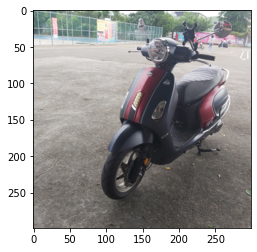

In [42]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# import 匯入 當初預處理的方式

p = df["path"]
idx = random.randint(0, len(p)-1)
img = Image.open(p[idx]).resize((299, 299)).convert("RGB")
img_np = np.array(img)
# VGG16 的資料是怎麼預處理的 ? google preprocess_input github
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
img_np_pre = tf.keras.applications.inception_resnet_v2.preprocess_input(img_np)
print(img_np_pre)
plt.imshow(img)

In [43]:
p

0       /content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...
1       /content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...
2       /content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...
3       /content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...
4       /content/drive/MyDrive/Tebame_第四組_機車辨識/原始照片(含外...
                              ...                        
6131    /content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...
6132    /content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...
6133    /content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...
6134    /content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...
6135    /content/drive/MyDrive/Tebame_第四組_機車辨識/裁剪照片(不含...
Name: path, Length: 6136, dtype: object

### generator

In [44]:
x = np.array(df["path"])
y = np.array(df["ans"])

In [47]:
def data_generator(x, y, batch_size=19):
  while True:
    idx = np.random.randint(0, len(x), size=batch_size)
    x_batch, y_batch = x[idx], y[idx]
    x_final = []
    for path in x_batch:
      img = Image.open(path).resize((299, 299)).convert("RGB")    #  開啟路徑圖檔並改大小、轉成RGB
      img_pre = tf.keras.applications.inception_resnet_v2.preprocess_input(np.array(img))              # 轉成陣列再預處理
      x_final.append(img_pre)            
    x_final = np.array(x_final)
    y_batch = np.array(y_batch)
    yield (x_final, y_batch)
gen = data_generator(x, y)
x_gen, y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
print(x_gen)
print(y_gen)


(19, 299, 299, 3)
(19,)
[[[[-0.30196077 -0.34117645 -0.30196077]
   [-0.21568626 -0.3098039  -0.24705881]
   [-0.10588235 -0.25490195 -0.20784312]
   ...
   [ 0.6862745   0.7254902   0.77254903]
   [ 0.6784314   0.7176471   0.7647059 ]
   [ 0.6862745   0.7254902   0.77254903]]

  [[ 0.47450984  0.4039216   0.39607847]
   [ 0.58431375  0.49803925  0.4901961 ]
   [ 0.69411767  0.62352943  0.62352943]
   ...
   [ 0.6156863   0.654902    0.7019608 ]
   [ 0.6313726   0.67058825  0.7176471 ]
   [ 0.64705884  0.6862745   0.73333335]]

  [[ 0.8509804   0.7882353   0.79607844]
   [ 0.8352941   0.78039217  0.78039217]
   [ 0.8745098   0.81960785  0.8117647 ]
   ...
   [ 0.5058824   0.54509807  0.60784316]
   [ 0.5137255   0.5529412   0.6156863 ]
   [ 0.52156866  0.56078434  0.62352943]]

  ...

  [[ 0.30196083  0.28627455  0.2313726 ]
   [ 0.33333337  0.254902    0.17647064]
   [ 0.3176471   0.12941182 -0.15294117]
   ...
   [-0.19999999 -0.21568626 -0.27058822]
   [-0.19999999 -0.21568626 -0.27

In [48]:
gp_x = x[y == 0]
vivo_x = x[y == 1]
gryphus6_x = x[y == 2]
SR_x = x[y == 3]
DRG_x = x[y == 4]
FIDDLE_x = x[y == 5]
S2_x = x[y == 6]
print("gp 共:", len(gp_x))
print("活力 共:", len(vivo_x))
print("勁戰6 共:", len(gryphus6_x))
print("SR 共:", len(SR_x))
print("DRG 共:", len(DRG_x))
print("FIDDLE 共:", len(FIDDLE_x))
print("S2 共:", len(S2_x))

gp 共: 552
活力 共: 786
勁戰6 共: 1250
SR 共: 609
DRG 共: 828
FIDDLE 共: 1317
S2 共: 794


In [49]:
from sklearn.model_selection import train_test_split

 # gp + vivo + gryphus6 + SR + DRG + FIDDLE + S2

gp_500 = np.random.choice(gp_x, 500, replace=False)
gp_450, gp_50 = train_test_split(gp_500, test_size=0.1)

vivo_500 = np.random.choice(vivo_x, 500, replace=False)
vivo_450, vivo_50 = train_test_split(vivo_500, test_size=0.1)

gryphus6_500 = np.random.choice(gryphus6_x, 500, replace=False)
gryphus6_450, gryphus6_50 = train_test_split(gryphus6_500, test_size=0.1)

SR_500 = np.random.choice(SR_x, 500, replace=False)
SR_450, SR_50 = train_test_split(SR_500, test_size=0.1)

DRG_500 = np.random.choice(DRG_x, 500, replace=False)
DRG_450, DRG_50 = train_test_split(DRG_500, test_size=0.1)

FIDDLE_500 = np.random.choice(FIDDLE_x, 500, replace=False)
FIDDLE_450, FIDDLE_50 = train_test_split(FIDDLE_500, test_size=0.1)

S2_500 = np.random.choice(S2_x, 500, replace=False)
S2_450, S2_50 = train_test_split(S2_500, test_size=0.1)


x_train = np.concatenate((gp_450, vivo_450, gryphus6_450, SR_450, DRG_450, FIDDLE_450, S2_450))
y_train = np.array([0] * len(gp_450) + [1] *len(vivo_450) + [2] *len(gryphus6_450) + [3] *len(SR_450) + [4] *len(DRG_450) + [5] *len(FIDDLE_450) + [6] *len(S2_450))
x_test = np.concatenate((gp_50, vivo_50, gryphus6_50, SR_50, DRG_50, FIDDLE_50, S2_50))
y_test = np.array([0] * len(gp_50) + [1] *len(vivo_50) + [2] *len(gryphus6_50) + [3] *len(SR_50) + [4] *len(DRG_50) + [5] *len(FIDDLE_50) + [6] *len(S2_50))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3150,)
(350,)
(3150,)
(350,)


In [50]:
train_generator = data_generator(x_train, y_train)
test_generator = data_generator(x_test, y_test)

In [ ]:
# 20 * 19 => 380訓練
# 5 * 19 => 38測試
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
             EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint("scooter.h5", save_best_only=True)
]

model.fit_generator(
    train_generator,
    steps_per_epoch=20,
    epochs=100,
    validation_data=test_generator,
    validation_steps=2, 
    callbacks=callbacks
                    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 291s 13s/step - loss: 1.9170 - acc: 0.1711 - val_loss: 304.2386 - val_acc: 0.1316
Epoch 2/100
12/20 [=================>............] - ETA: 1:25 - loss: 1.9158 - acc: 0.2018

In [ ]:
ori_imgs = []
for p in x_test:
    img = Image.open(p).resize((299, 299)).convert("RGB")
    ori_imgs.append(np.array(img))
ori_imgs = np.array(ori_imgs)
preprocess_imgs = preprocess_input(ori_imgs)

pre = model.predict(preprocess_imgs)



In [ ]:
pre = pre.argmax(axis=1)

In [ ]:
trans = ["gp", "vivo", "gryphus6", "SR", "DRG", "FIDDLE", "S2"]
 # gp + vivo + gryphus6 + SR + DRG + FIDDLE + S2
idx = np.nonzero(pre != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(15, 15))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, pre)
pd.DataFrame(
        mat,
        index=["{}(正確)".format(trans[i]) for i in range(7)],
        columns=["{}(預測)".format(trans[i]) for i in range(7)]
)

In [ ]:
# import requests
# url = input("Enter:")
# response = requests.get(url, stream=True, verify=False)
# img = Image.open(response.raw).resize((299, 299)).convert("RGB")
# img_np = preprocess_input(np.array(img).reshape(1, 299, 299, 3))
# proba = model.predict(img_np)
# ans = proba.argmax(axis=1)
# print("預測:", trans[ans[0]])
# print("機率:", proba[0])
# plt.imshow(img)
#trans = ["gp", "vivo", "gryphus6", "SR", "DRG", "FIDDLE", "S2"]